# battle plan

## rebuild RPG2k3 systems in `elm-engine`

- <span style="color:green">[**easy**]</span> render map with WebGL 

- <span style="color:green">[**easy**]</span> input, navigation 
  - <span style="color:gray">[**???**]</span> world tree
  
- <span style="color:red">[**hard**]</span> event system
  - global environment
  - embedded scripting, expose Elm functions

- <span style="color:red">[**hard**]</span> implement events
  - load map files
  - translate `Event`, `EventCommand`
  - message
  - choices
  - set!
  - time elapsed
  - change state: inventory, etc (callbacks on failure?)
- <span style="color:red">[**also hard**]</span> animated events
    - 

- <span style="color:red">[**hard**]</span> graphic effects
  - color saturation
  - distort (vertex buffer?)
  - shader combinators?

## better tools

- `lister`: console, editing, custom views
- `timeline`: message stream, scroll through scenes 
- plot tree? 

# engine types

```elm
type alias Model = 
  { entities : List Entity
  , commands : List (Tree Parallel|Serial Command)
    -- Branch Parallel|Serial (List (Tree Command)) | Leaf Command
  , clock : Clock -- (wall time, game time, tick ratio)
  , state : State -- (Dialog, Menu, Battle, Map)
  , render : RenderOptions 
  , resources : Collection XML (Texture, etc)
  , seed : RandomSeed
  , gamepad : Gamepad -- {up: Bool, down, A, B, X, Y etc}
  }


type Entity =
  Entity
  { position : Maybe Vec2
  , orientation : Maybe Vec2
  , animation : Maybe (Animation Entity)
  , event : Maybe (Event Entity)
  , sprite : Maybe Sprite
  , inventory : Maybe Inventory
  }


type Message 
  = AddCommand CommandTree -- could also track these 
  | Input GamePadPress
  | Elapsed AnimationFrame
  | ListerMsg Lister.Message


```

###### how to tackle animation?

`{animation: AnimationState -> Time -> Object -> Object}`

where Object has only relevant fields (e.g., position, orientation, sprite angle)
might need option to chain/combine animations

sequential commands?
could load commands into a global pipeline (after marking with event ID)
tree of commands, lists marked Parallel or Serial. maybe some dummy events to coordinate. 

global transitions?
- dialog, menu, battle
- top level union type, view dispatches w/ case statement
- top level clock (wall time, game time, tick ratio)



### lister resources

https://gribouille.github.io/demos/elm-treeview/latest/

In [35]:
get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')

In [102]:
from bs4 import BeautifulSoup
from collections import Counter

f = '../Resources/Map0012.emu'
soup = BeautifulSoup(open(f, 'r').read())
layer = soup.find_all('lower_layer')[0]

soup.find_all('name')

[<name>AirshipFlight</name>]

In [179]:
indices = layer.contents[0].split()
indices = np.array(indices).reshape(80,80).astype(int)
# img = Image.fromarray(indices)
# img.save('../../test.png')

In [230]:
f = '../resources/ChipSet/main.png'
img = Image.open(f).convert('RGB')
chipset = np.asarray(img)

In [247]:
b_subtile = 0
for i in (0, 1):
    for j in (0, 1):
        print (b_subtile >> (j * 2 + i)) & 1

0
0
0
0


In [269]:
cache = {}
arr = []
bad_indices = []
blank_tile = np.zeros_like(chipset)[:16, :16]
animID = 2
for index in indices.flatten():
    try:
        tile = cache[index]
    except KeyError:
        if 0 <= index < 100:
            tiles_ij = tools.find_blockAB_quadrants(index, animID)
            tile = tools.assemble_quadrants(chipset, tiles_ij)            
        elif 4000 <= index < 4700:
            tiles_ij = tools.find_blockD_quadrants(index)
            tile = tools.assemble_quadrants(chipset, tiles_ij)
        else:
            tile = blank_tile
            bad_indices.append(index)
            
    cache[index] = tile 
    arr.append(tile)
        
    
        
arr = [a.transpose([2, 0, 1]) for a in arr]
arr = tools.montage(arr).transpose([1, 2, 0])

In [270]:
Image.fromarray(arr).save('../../airship_%d.png' % animID)

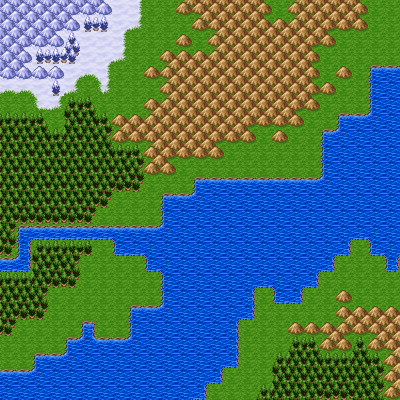

In [264]:
img = Image.fromarray(arr[:400, :400])
img

In [120]:
import tools
tools.run()

padding 22 images...
done
cleaning 54 files...
done


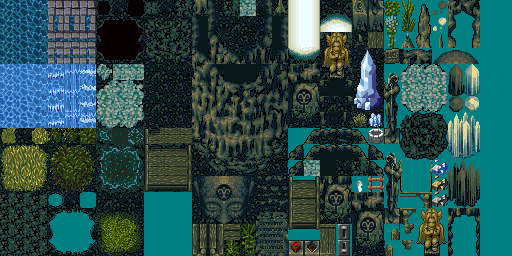

In [26]:
f = '../resources/ChipSet/cave15.png'
pad_image(f)

### resource resources

- https://github.com/EasyRPG/Player/blob/7f8fd909c659035660f2a364426acd30ed34358e/src/tilemap_layer.cpp#L32
- https://opengameart.org/content/terrain-transitions
- https://www.spriters-resource.com/snes/ff6/sheet/54728/
- https://rpgmaker.net/tutorials/975/
- http://www.pathofexile.com/forum/view-thread/55091
- voxel farm

- convert `{chipset_id, index}` to `{texture, position}`
- read/write internal representation to Tiled formats (`.tmx`, `.tsx`)
  - RPG2k3 upper/lower layers => Tiled layers
  - tileset info (e.g., passable) in Tiled types
